<a href="https://colab.research.google.com/github/pranayj77/Covid19-Classifier/blob/main/COVID_19_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from zipfile import ZipFile
from tensorflow.keras.layers import *

from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from glob import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import ImageFile
import random
%matplotlib inline
# import the libraries as shown below

Preprocessing 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_folder = '/content/drive/MyDrive/Medical Imaging Project/COVID-19_Radiography_Dataset'
covid_data = data_folder +'/Data/COVID/'
normal_data = data_folder +'/Data/Normal/'
viral_data = data_folder +'/Viral Pneumonia/'

cov_images = glob(covid_data+'*.png')
nor_images = glob(normal_data+'*.png')
vir_images = glob(viral_data+'*.png')


In [ ]:
data_folder = '/content/drive/MyDrive/Medical Imaging Project/COVID-19_Radiography_Dataset'
data = data_folder+'/Data/';
print(data)

/content/drive/MyDrive/Medical Imaging Project/COVID-19_Radiography_Dataset/Data/


<function matplotlib.pyplot.show>

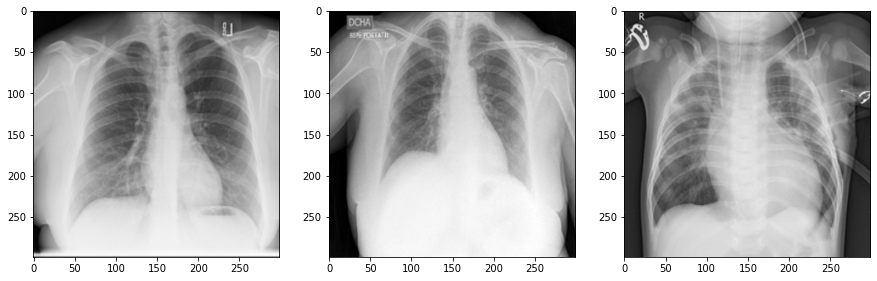

In [ ]:
cov_im = np.asarray(plt.imread(cov_images[random.randint(1,len(cov_images))]))
nor_im = np.asarray(plt.imread(nor_images[random.randint(1,len(nor_images))]))
vir_im = np.asarray(plt.imread(vir_images[random.randint(1,len(vir_images))]))

fig = plt.figure(figsize = (15,10))
nor_plt = fig.add_subplot(1,3,1)
plt.imshow(nor_im, cmap = 'gray')

cov_plt = fig.add_subplot(1,3,2)
plt.imshow(cov_im, cmap = 'gray')

vir_plt = fig.add_subplot(1,3,3)
plt.imshow(vir_im, cmap = 'gray')

plt.show

In [ ]:
img_size = list(np.shape(cov_im))
print(img_size+[3])

[299, 299, 3]


In [ ]:
from collections import Counter
train_datagen2 = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator2 = train_datagen2.flow_from_directory(
    data,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='training') # set as training data

counter = Counter(train_generator2.classes)
max_val = float(max(counter.values()))
class_weights = {
   class_id: max_val / num_images
   for class_id,
   num_images in counter.items()
}

validation_generator2 = train_datagen2.flow_from_directory(
    data, # same directory as training data
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='validation') # set as validation data




Found 11047 images belonging to 2 classes.
Found 2761 images belonging to 2 classes.


In [ ]:
print(class_weights)

{0: 2.8185274801244384, 1: 1.0}


Model Design

In [ ]:
res = ResNet50(classes=2,include_top=False,input_shape = tuple([255,255,3]),weights='imagenet')


94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
res = ResNet50(classes=2,include_top=False,input_shape = tuple([255,255,3]),weights='imagenet')


In [ ]:
for layer in res.layers:
    layer.trainable = False

Model 3 (Resnet with Dense Layers)

In [ ]:
x=res.output
x=GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
out=Dense(2,activation='softmax')(x)
model3 = Model(inputs=res.input, outputs=out)

In [ ]:
model3.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
model3.summary()

In [ ]:
import tensorflow.keras.layers as layers
model = tf.keras.models.Sequential([
      layers.BatchNormalization(),
      layers.Conv2D(64, 3, activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(0.3),
      layers.Conv2D(128,3,activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(256, 3, activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(0.3),
      layers.Conv2D(512, 3, activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(0.2),
      layers.Flatten(),
      layers.Dense(1024, activation='relu'),
      layers.Dropout(0.15),
      layers.Dense(2, activation= 'softmax')
    ])

In [ ]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

Model1 Resnet with Flatten and Dense Layer

In [ ]:
print(res.output)
x = Flatten()(res.output)
prediction = Dense(2, activation='softmax')(x)

mod = Model(inputs=res.input, outputs=prediction)



KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 2048), dtype=tf.float32, name=None), name='conv5_block3_out/Relu:0', description="created by layer 'conv5_block3_out'")


In [ ]:
mod.summary()

Fit Models 

In [ ]:

# fit the CNN model
# Run the cell. It will take some time to execute
r1 = model.fit(
  train_generator2,
  validation_data=validation_generator2,
  epochs=20,
  class_weight = class_weights
)

In [ ]:

# fit the Resnet50 model
# Run the cell. It will take some time to execute
r3 = model3.fit(
  train_generator2,
  validation_data=validation_generator2,
  epochs=5,
  class_weight = class_weights
)

In [ ]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  fig, ax = plt.subplots(1,2,figsize=(20,10))
  ax[0].plot(epochRange,history.history['accuracy'],'b',label = 'Training Accuracy')
  ax[0].plot(epochRange,history.history['val_accuracy'],'r',label = 'Validation Accuracy')
  ax[0].set_title('Training and Validation accuracy')
  ax[0].set_xlabel('Epoch', fontsize = 20)
  ax[0].set_ylabel('Accuracy', fontsize = 20)
  ax[0].legend()
  ax[0].grid(color='gray', linestyle='--')
  ax[1].plot(epochRange,history.history['loss'],'b',label = 'Training Loss')
  ax[1].plot(epochRange,history.history['val_loss'],'r',label = 'Validation Loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Epoch', fontsize = 20)
  ax[1].set_ylabel('Loss', fontsize = 20)
  ax[1].legend()
  ax[1].grid(color='gray', linestyle='--')
  plt.show()

plotLearningCurve(r,20)

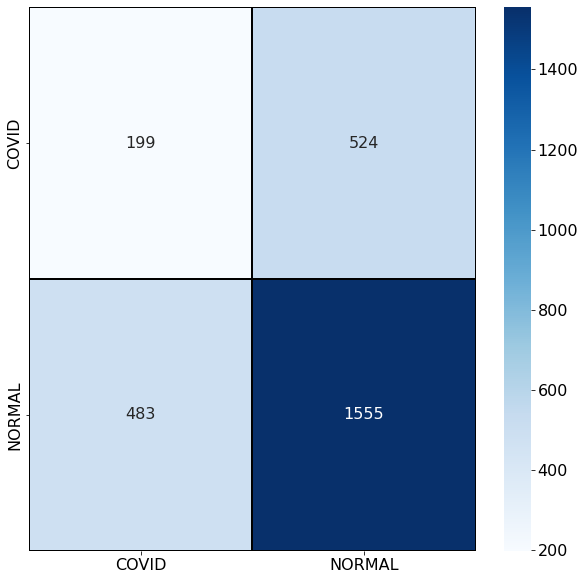

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
plt.rcParams.update({'font.size': 16})
predictions = mod.predict(validation_generator2)
predictions = np.argmax(predictions,axis=1)
predictions[:15]
cm = confusion_matrix(validation_generator2.classes, predictions)
cm = pd.DataFrame(cm, index = ['0', '1'], columns = ['0', '1'])
cm
class_names = ['COVID','NORMAL']
def plot_confusion_matrix (cm):
    plt.figure(figsize = (10,10))
    sns.heatmap(
        cm, 
        cmap = 'Blues', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt = '', 
        xticklabels = class_names, 
        yticklabels = class_names)
    
plot_confusion_matrix(cm)

Epoch 1/5
10/10 [==============================] - 81s 9s/step - loss: 0.5682 - accuracy: 0.7344 - precision: 0.7344 - recall: 0.7344 - val_loss: 0.5295 - val_accuracy: 0.7381 - val_precision: 0.7381 - val_recall: 0.7381
Epoch 2/5
10/10 [==============================] - 81s 9s/step - loss: 0.5803 - accuracy: 0.7250 - precision: 0.7250 - recall: 0.7250 - val_loss: 0.5316 - val_accuracy: 0.7381 - val_precision: 0.7381 - val_recall: 0.7381
Epoch 3/5
10/10 [==============================] - 82s 9s/step - loss: 0.5065 - accuracy: 0.7688 - precision: 0.7688 - recall: 0.7688 - val_loss: 0.5521 - val_accuracy: 0.7381 - val_precision: 0.7381 - val_recall: 0.7381
Epoch 4/5
10/10 [==============================] - 82s 9s/step - loss: 0.5765 - accuracy: 0.7250 - precision: 0.7250 - recall: 0.7250 - val_loss: 0.5420 - val_accuracy: 0.7381 - val_precision: 0.7381 - val_recall: 0.7381
Epoch 5/5
10/10 [==============================] - 83s 9s/step - loss: 0.5391 - accuracy: 0.7594 - precision: 0.7594

Save Model and other miscellaneuos code blocks


In [ ]:
mod.save('/content/drive/MyDrive/Medical Imaging Project/model3/')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Medical Imaging Project/model3/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


https://medium.com/@kenneth.ca95/a-guide-to-transfer-learning-with-keras-using-resnet50-a81a4a28084b

https://github.com/beingnitisho7/LungsDiseasePredictionCNN_VGG_ResNet/blob/master/Xray_resnet.ipynb



https://iq.opengenus.org/basics-of-machine-learning-image-classification-techniques/

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8095476/

In [ ]:
mod5 = tensorflow.keras.models.load_model('/content/drive/MyDrive/Medical Imaging Project/model3/')

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Medical Imaging Project/model3/', monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]